## Train FastText embedding

In [ ]:
# install gensim 4.0+
!pip uninstall gensim &> /dev/null
!pip install git+https://github.com/piskvorky/gensim.git@develop &> /dev/null

In [ ]:
from google.colab import drive
drive.mount('/content/drive')

Mounted at /content/drive


In [ ]:
import os
import glob
import time
import json
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
import gc
import warnings
warnings.filterwarnings('ignore')

import gensim
from gensim.models import FastText
from gensim.utils import tokenize
from gensim.test.utils import datapath
import gensim.downloader as api
from gensim.models.callbacks import CallbackAny2Vec
print(f"gensim version: {gensim.__version__}")

gensim version: 4.1.3.dev0


In [ ]:
# set working directory
# cwd = "drive/MyDrive/Topic Modeling" # Ximin
cwd = "drive/Shareddrives/AV_Twitter_Project/Topic Modeling" # Ran

# make exp path
exp_path = os.path.join(cwd, "exp", "fasttext")
if not os.path.exists(exp_path):
    os.mkdir(exp_path)

In [ ]:
def remove_tags(df):
    """ remove tweet-processor lib tags """
    # python does not allow $XXX$ symbols
    df = df.str.replace("$", "")
    df = df.str.replace("URL", "")
    df = df.str.replace("HASHTAG", "")
    df = df.str.replace("MENTION", "")
    df = df.str.replace("RESERVED", "")
    df = df.str.replace("EMOJI", "")
    df = df.str.replace("SMILEY", "")
    df = df.str.replace("NUMBER", "")
    return df

def load_data(data_paths):
    print(f"loading data...")
    df = []
    start_time = time.time()
    for i, data_path in enumerate(data_paths):
        filename = os.path.basename(data_path)
        df_event = pd.read_csv(data_path, lineterminator="\n")
        df_event["tokens"] = remove_tags(df_event["tokens"].astype(str))
        df.append(df_event)
        
        print(
            "{}, {}, time: {:.2f}, data size: {}".format(
            i, filename, time.time() - start_time, df_event.shape
            )
        )

    df = pd.concat(df)
    df = df.drop_duplicates(subset=["tokens"]).reset_index(drop=True)
    return df

In [ ]:
# load sample data
data_paths = glob.glob(os.path.join(cwd, "data/opinion_modeling/raw_csv/", "*.csv"))
df = load_data(data_paths)
print(f"data size: {df.shape}")

loading data...
0, confused_tesla_incident_in_february.csv, time: 2.00, data size: (67689, 15)
1, mcity_driverless_shuttle_launches_on_um_north_campus.csv, time: 4.25, data size: (85512, 15)
2, las_vegas_autonomous_shuttle_crash.csv, time: 5.71, data size: (44651, 15)
3, introduction_of_tesla_autopilot.csv, time: 7.03, data size: (32521, 15)
4, world_first_production_car_to_offer_level_3_automation.csv, time: 9.02, data size: (43103, 15)
5, google_lexus_suv.csv, time: 11.21, data size: (51748, 15)
6, tesla_model_x_fatality.csv, time: 13.92, data size: (129713, 15)
7, march_1st_2019_highway_crash_fatality.csv, time: 16.93, data size: (93357, 15)
8, tesla_model_s_fatal_crash_in_china.csv, time: 18.33, data size: (36941, 15)
9, uber_self_driving_volvo_crash.csv, time: 21.91, data size: (117840, 15)
10, university_of_michigan_mcity.csv, time: 23.55, data size: (42768, 15)
11, first_automated_vehicle_crash_fatality_takes_place.csv, time: 25.99, data size: (92817, 15)
data size: (682084, 15)

In [ ]:
class TweetLoader():
    def __init__(self, df):
        self.df = df
    
    def __len__(self):
        return len(self.df)

    def __iter__(self):
        for i in range(len(self)):
            yield list(tokenize(self.df["tokens"].iloc[i]))

class EpochLogger(CallbackAny2Vec):
    def __init__(self, verbose):
        self.verbose = verbose
        self.start_time = time.time()
        self.epoch = 0
        self.history = []

    def on_epoch_end(self, model):
        # use wordsim353.tsv or simlex999.txt for word pair eval
        pearson, spearman, oov_ratio = model.wv.evaluate_word_pairs(
            datapath("wordsim353.tsv") 
        )
        score, sections = model.wv.evaluate_word_analogies(
            datapath("questions-words.txt")
        )
        
        self.history.append({
            "epoch": self.epoch,
            # "loss": loss,
            "word_pair_corr": pearson[0],
            "word_analogy_score": score,
            "time": time.time() - self.start_time
        })
        self.epoch += 1
        if self.verbose:
            print({k: round(v, 3) for k, v in self.history[self.epoch-1].items()})

In [ ]:
def main(df, config):
    """ train a FastText embedding model """
    # subsample data
    if config["debug"]:
        df = df.sample(n=1000, random_state=config["seed"])
    else:
        df = df.sample(frac=config["sample_ratio"], random_state=config["seed"])
    
    # init loader
    tweet_loader = TweetLoader(df)
    print(f"subsample data size: {len(tweet_loader)}")
    
    # init logger
    logger = EpochLogger(config["verbose"])
    
    # init model
    model = FastText(
        vector_size=config["embedding_size"], 
        window=config["window"], 
        min_count=config["min_count"],  
        min_n=2, # min ngram len
        max_n=6, # max ngram len
        alpha=config["lr"],
        min_alpha=1e-5, 
        seed=config["seed"]
    )

    # build vocab
    start_time = time.time()
    model.build_vocab(tweet_loader)
    print(f"vocab size: {len(model.wv.index_to_key)}, time: {time.time() - start_time:.2f}")
    
    # train
    start_time = time.time()
    for e in range(config["epochs"]):
        model.train(
            tweet_loader,
            total_examples=len(tweet_loader),
            epochs=1, 
            compute_loss=True,
            callbacks=[logger]
        )
        if config["debug"]:
            break

    df_history = pd.DataFrame(logger.history)
    
    # test 
    pearson, spearman, oov_ratio = model.wv.evaluate_word_pairs(
        datapath("wordsim353.tsv") # use wordsim353.tsv or simlex999.txt
    )
    score, sections = model.wv.evaluate_word_analogies(
        datapath("questions-words.txt")
    )
    print("epoch: {}, word_pair_corr: {}, word_analogy_score: {}".format(
        e, 
        round(pearson[0], 3), 
        round(score, 3), 
        round(time.time() - start_time, 3)
    ))

    # save
    if config["save"]:
        # make save path
        save_path = os.path.join(
            exp_path,
            "sample_ratio_{}_embedding_size_{}_window_{}_min_count_{}_lr_{}_seed_{}".format(
                config["sample_ratio"],
                config["embedding_size"],
                config["window"],
                config["min_count"],
                config["lr"],
                config["seed"],
            )
        )
        if not os.path.exists(exp_path):
            os.mkdir(exp_path)
        if not os.path.exists(save_path):
            os.mkdir(save_path)

        # save config
        with open(os.path.join(save_path, "args.json"), "w") as f:
            json.dump(config, f)
        
        # save history
        df_history.to_csv(os.path.join(save_path, "history.csv"), index=False)

        # save model
        model.save(os.path.join(save_path, "model.m"))
    
    print(f"done, results saved: {config['save']}")
    return model, df_history

## Manual training

In [ ]:
config = {
    "seed": 0,
    "sample_ratio": 0.5,
    "embedding_size": 50,
    "window": 5,
    "min_count": 2,
    "lr": 0.05,
    "epochs": 20,
    "verbose": True,
    "debug": False,
    "save": False
}

trained_model, df_history = main(df, config)

subsample data size: 341042
vocab size: 79745, time: 20.47
{'epoch': 0, 'word_pair_corr': 0.054, 'word_analogy_score': 0.134, 'time': 113.623}
{'epoch': 1, 'word_pair_corr': 0.021, 'word_analogy_score': 0.287, 'time': 217.555}
{'epoch': 2, 'word_pair_corr': 0.119, 'word_analogy_score': 0.357, 'time': 324.931}
{'epoch': 3, 'word_pair_corr': 0.173, 'word_analogy_score': 0.368, 'time': 426.987}
{'epoch': 4, 'word_pair_corr': 0.217, 'word_analogy_score': 0.372, 'time': 530.49}
{'epoch': 5, 'word_pair_corr': 0.226, 'word_analogy_score': 0.374, 'time': 631.911}
{'epoch': 6, 'word_pair_corr': 0.247, 'word_analogy_score': 0.373, 'time': 735.54}
{'epoch': 7, 'word_pair_corr': 0.262, 'word_analogy_score': 0.369, 'time': 841.937}
{'epoch': 8, 'word_pair_corr': 0.27, 'word_analogy_score': 0.365, 'time': 969.383}
{'epoch': 9, 'word_pair_corr': 0.271, 'word_analogy_score': 0.365, 'time': 1096.962}
{'epoch': 10, 'word_pair_corr': 0.282, 'word_analogy_score': 0.359, 'time': 1222.451}
{'epoch': 11, 'wo

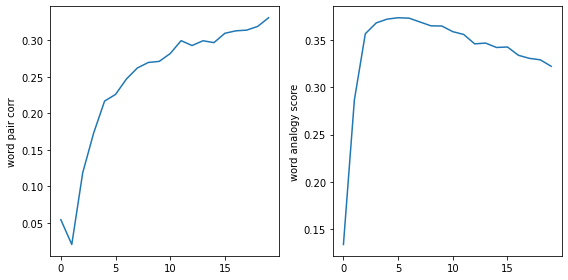

In [ ]:
# plot history
fig, ax = plt.subplots(1, 2, figsize=(8, 4))
ax[0].plot(df_history["word_pair_corr"])
ax[0].set_ylabel("word pair corr")
ax[1].plot(df_history["word_analogy_score"])
ax[1].set_ylabel("word analogy score")
plt.tight_layout()
plt.show()

In [ ]:
# word similarity eval
w = "audi"
print(w in trained_model.wv.index_to_key)
trained_model.wv.most_similar(w)

True


[('saudi', 0.7680677771568298),
 ('ascii', 0.7421726584434509),
 ('imdi', 0.7344834804534912),
 ('mercredi', 0.7270568013191223),
 ('alli', 0.7243671417236328),
 ('tudi', 0.7200636267662048),
 ('mardi', 0.7094587087631226),
 ('branche', 0.6999908089637756),
 ('edi', 0.6996476054191589),
 ('banche', 0.6956508755683899)]

In [ ]:
# test save model
trained_model.save("model.m")

# test load model
loaded_model = FastText.load("model.m")

## Grid search

In [ ]:
from sklearn.model_selection import ParameterGrid

In [ ]:
def grid_search(df, param_grid, debug=False):
    param_grid = list(param_grid)[-1:]
    print(f"grid search, num_grids: {len(param_grid)}...")
    
    for i, params in enumerate(param_grid):
        print("\n", i, params)

        config = {
            "seed": params["seed"],
            "sample_ratio": params["sample_ratio"],
            "embedding_size": params["embedding_size"],
            "window": params["window"],
            "min_count": params["min_count"],
            "lr": params["lr"],
            "epochs": params["epochs"],
            "verbose": params["verbose"],
            "debug": debug,
            "save": params["save"]
        }

        main(df, config)

        if debug and i > 0: 
            break

In [ ]:
param_grid = ParameterGrid(
    {
        "seed": [0], 
        "sample_ratio": [0.3, 0.8],
        "embedding_size": [50, 300],
        "window": [5],
        "min_count": [3],
        "lr": [0.05, 0.025],
        "epochs": [30],
        "verbose": [True],
        "save": [True]
    }
)

grid_search(df, param_grid, debug=False)

grid search, num_grids: 1...

 0 {'embedding_size': 300, 'epochs': 30, 'lr': 0.025, 'min_count': 3, 'sample_ratio': 0.8, 'save': True, 'seed': 0, 'verbose': True, 'window': 5}
subsample data size: 545667
vocab size: 74030, time: 28.01
{'epoch': 0, 'word_pair_corr': 0.09, 'word_analogy_score': 0.349, 'time': 232.017}
{'epoch': 1, 'word_pair_corr': -0.033, 'word_analogy_score': 0.216, 'time': 446.397}
{'epoch': 2, 'word_pair_corr': 0.04, 'word_analogy_score': 0.363, 'time': 660.001}
{'epoch': 3, 'word_pair_corr': 0.096, 'word_analogy_score': 0.415, 'time': 874.983}
{'epoch': 4, 'word_pair_corr': 0.145, 'word_analogy_score': 0.446, 'time': 1089.319}
{'epoch': 5, 'word_pair_corr': 0.17, 'word_analogy_score': 0.463, 'time': 1305.902}
{'epoch': 6, 'word_pair_corr': 0.198, 'word_analogy_score': 0.471, 'time': 1520.497}
{'epoch': 7, 'word_pair_corr': 0.219, 'word_analogy_score': 0.475, 'time': 1735.416}
{'epoch': 8, 'word_pair_corr': 0.243, 'word_analogy_score': 0.479, 'time': 1951.14}
{'epoch

## Model selection

In [ ]:
def load_model(path):
    # load args
    with open(os.path.join(path, "args.json"), "rb") as f:
        config = json.load(f)

    # load model
    model = FastText.load(os.path.join(path, "model.m"))

    # load history
    df_history = pd.read_csv(os.path.join(path, "history.csv"))
    return model, config, df_history

In [ ]:
debug = False
result_paths = glob.glob(os.path.join(exp_path, "*/"))

start_time = time.time()
test_stats = []
for i, path in enumerate(result_paths):
    print(i, os.path.basename(os.path.dirname(path)))
    model, config, df_history = load_model(path)
    
    # vocab size
    vocab_size = len(model.wv.index_to_key)

    # pack results
    stats = config
    stats.update(df_history.iloc[-1].to_dict())
    stats.update({"vocab_size": vocab_size})
    test_stats.append(stats)

    if debug and i > 0:
        break

print(f"time: {(time.time() - start_time):.2f}")

gc.collect() # clear cache
df_stats = pd.DataFrame(test_stats)

# save stats
if not debug:
    df_stats.to_csv(os.path.join(exp_path, "model_comparison.csv"), index=False)

0 sample_ratio_0.3_embedding_size_50_window_5_min_count_3_lr_0.05_seed
1 sample_ratio_0.8_embedding_size_50_window_5_min_count_3_lr_0.05_seed
2 sample_ratio_0.3_embedding_size_50_window_5_min_count_3_lr_0.025_seed
3 sample_ratio_0.8_embedding_size_50_window_5_min_count_3_lr_0.025_seed
4 sample_ratio_0.3_embedding_size_300_window_5_min_count_3_lr_0.05_seed
5 sample_ratio_0.8_embedding_size_300_window_5_min_count_3_lr_0.05_seed
6 sample_ratio_0.3_embedding_size_300_window_5_min_count_3_lr_0.025_seed
7 sample_ratio_0.8_embedding_size_300_window_5_min_count_3_lr_0.025_seed
time: 238.44


In [ ]:
df_stats

,seed,sample_ratio,embedding_size,window,min_count,lr,epochs,verbose,debug,save,epoch,word_pair_corr,word_analogy_score,time,vocab_size
0,0,0.3,50,5,3,0.050,30,True,False,True,29.0,0.375022,0.321750,1645.024891,41402
1,0,0.8,50,5,3,0.050,30,True,False,True,29.0,0.374567,0.294049,4829.486936,74030
2,0,0.3,50,5,3,0.025,30,True,False,True,29.0,0.324327,0.435470,1582.132579,41402
3,0,0.8,50,5,3,0.025,30,True,False,True,29.0,0.307900,0.362357,4090.474690,74030
4,0,0.3,300,5,3,0.050,30,True,False,True,29.0,0.397401,0.372219,3430.958859,41402
5,0,0.8,300,5,3,0.050,30,True,False,True,29.0,0.437648,0.335092,8914.242210,74030
6,0,0.3,300,5,3,0.025,30,True,False,True,29.0,0.308683,0.485655,3460.371530,41402
7,0,0.8,300,5,3,0.025,30,True,False,True,29.0,0.376940,0.436822,6377.227926,74030


Comments:

1. More data makes analogy score worse
2. Higher lr improves word pair score but decrease word analogy score
3. embedding_size = 300

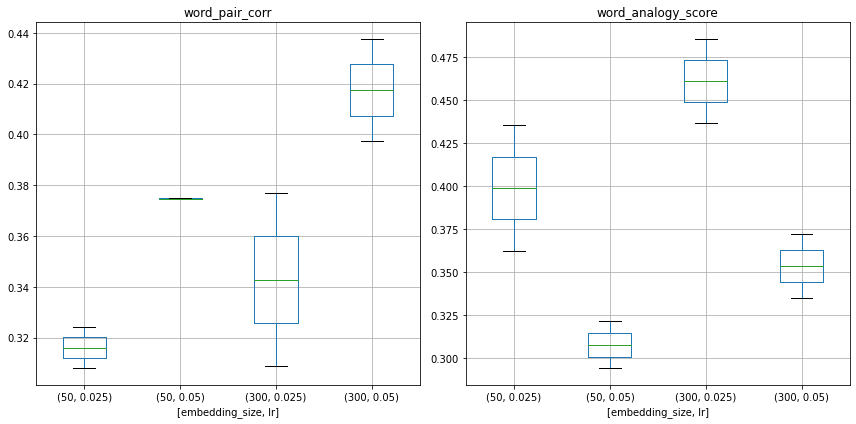

In [ ]:
# plot stats
by_cols = ["embedding_size", "lr"]
fig, ax = plt.subplots(1, 2, figsize=(12, 6))
df_stats.boxplot(column="word_pair_corr", by=by_cols, ax=ax[0])
df_stats.boxplot(column="word_analogy_score", by=by_cols, ax=ax[1])
plt.suptitle("")
plt.tight_layout()
plt.show()

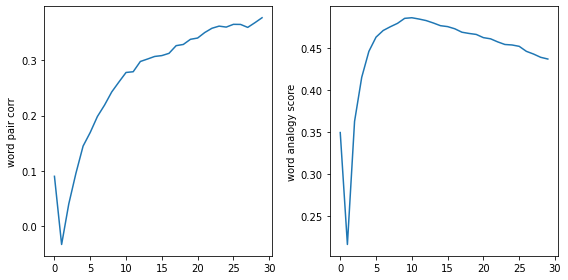

In [ ]:
# example learning curve
fig, ax = plt.subplots(1, 2, figsize=(8, 4))
ax[0].plot(df_history["word_pair_corr"])
ax[0].set_ylabel("word pair corr")
ax[1].plot(df_history["word_analogy_score"])
ax[1].set_ylabel("word analogy score")
plt.tight_layout()
plt.show()

In [ ]:
# word similarity eval
w = "AV"
print(w in model.wv.index_to_key)
model.wv.most_similar(w)

True


[('AVZ', 0.8190524578094482),
 ('AVI', 0.7803251147270203),
 ('UAV', 0.7714591026306152),
 ('SAV', 0.76778244972229),
 ('AVG', 0.7509245276451111),
 ('NAV', 0.742714524269104),
 ('FAV', 0.7301045060157776),
 ('CAV', 0.718357503414154),
 ('RAV', 0.703980028629303),
 ('AVs', 0.6878001093864441)]